In [1]:
# ruff: noqa: PD901
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline


# Built-in modules
import os
import random
from datetime import datetime, timedelta
from pathlib import Path

# Basics of Python data handling and visualization
import numpy as np

rng = np.random.default_rng(42)
import warnings

import geopandas as gpd
import joblib

# Machine learning
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Imports from eo-learn and sentinelhub-py
from eolearn.core import (
    EOExecutor,
    EOPatch,
    EOTask,
    EOWorkflow,
    FeatureType,
    LoadTask,
    OverwritePermission,
    SaveTask,
    linearly_connect_tasks,
)
from eolearn.geometry import ErosionTask, VectorToRasterTask
from eolearn.io import SentinelHubEvalscriptTask, VectorImportTask
from eolearn.ml_tools import FractionSamplingTask
from imblearn.under_sampling import RandomUnderSampler
from sentinelhub import BBoxSplitter, DataCollection, SHConfig
from shapely.geometry import Polygon
from sklearn import preprocessing

warnings.filterwarnings("ignore")

/Users/chung-xianghong/Documents/git/sh-ai-stac/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = SHConfig()
config.sh_base_url = "https://creodias.sentinel-hub.com"

hrvpp = DataCollection.define_byoc("67c73156-095d-4f53-8a09-9ddf3848fbb6")

In [3]:
# Folder where data for running the notebook is stored
DATA_FOLDER = Path("..", "data")
# Locations for collected data and intermediate results
EOPATCH_FOLDER = Path("..", "eolearn-out/eopatches")
EOPATCH_SAMPLES_FOLDER = Path("..", "eolearn-out/eopatches_sampled")
GRIDS_FOLDER = Path("..", "grids")
MODELS_FOLDER = Path("..", "models")
for folder in (EOPATCH_FOLDER, EOPATCH_SAMPLES_FOLDER, GRIDS_FOLDER):
    folder.mkdir(exist_ok=True, parents=True)

##### 1. Define the Area-of-Interest (AOI):

We are defining all of Netherlands as the Area of Interest.

Dimension of the area is 280302 x 312610 m2


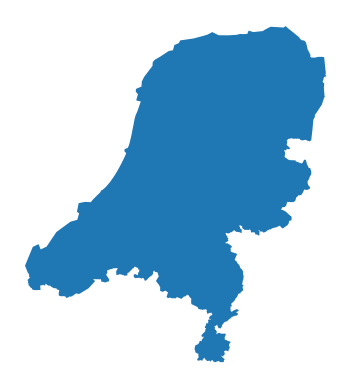

In [4]:
# Load geojson file
country = gpd.read_file(DATA_FOLDER / "NL_BORDER.geojson").to_crs(3035)
# Add 500m buffer to secure sufficient data near border
country = country.buffer(500)

# Get the country's shape in polygon format
country_shape = country.geometry.values[0]

# Plot country
country.plot()
plt.axis("off")

# Print size
country_width = country_shape.bounds[2] - country_shape.bounds[0]
country_height = country_shape.bounds[3] - country_shape.bounds[1]
print(f"Dimension of the area is {country_width:.0f} x {country_height:.0f} m2")

#### Preparation of EOPatches

EOPatches are the data structure which allows eo-learn to perform the data preparation at a large scale.
They hold all types of geospatial data for a specific bounding box. The workflow which will be defined is then applied to all EOPatches individually which makes operations at large scale possible.

In our case we are splitting up Netherlands into many small bounding boxes for which data is later being downloaded. 
To keep the whole workflow lighter for now we are only selecting 100 random bounding boxes.

In [5]:
# Create a splitter to obtain a list of bboxes with 5km sides
bbox_splitter = BBoxSplitter([country_shape], country.crs, split_size=5000)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]
idxs = list(range(len(idxs_x)))  # [info["index"] for info in info_list]

bbox_gdf = gpd.GeoDataFrame({"index": idxs, "index_x": idxs_x, "index_y": idxs_y}, crs=country.crs, geometry=geometry)

number_of_patches = 20
# pick a number of patches
patch_ids = random.sample(range(len(bbox_list)), number_of_patches)

# Save to shapefile
shapefile_name = "grid_netherlands_500x500.gpkg"
bbox_gdf.to_file(os.path.join(GRIDS_FOLDER, shapefile_name), driver="GPKG")

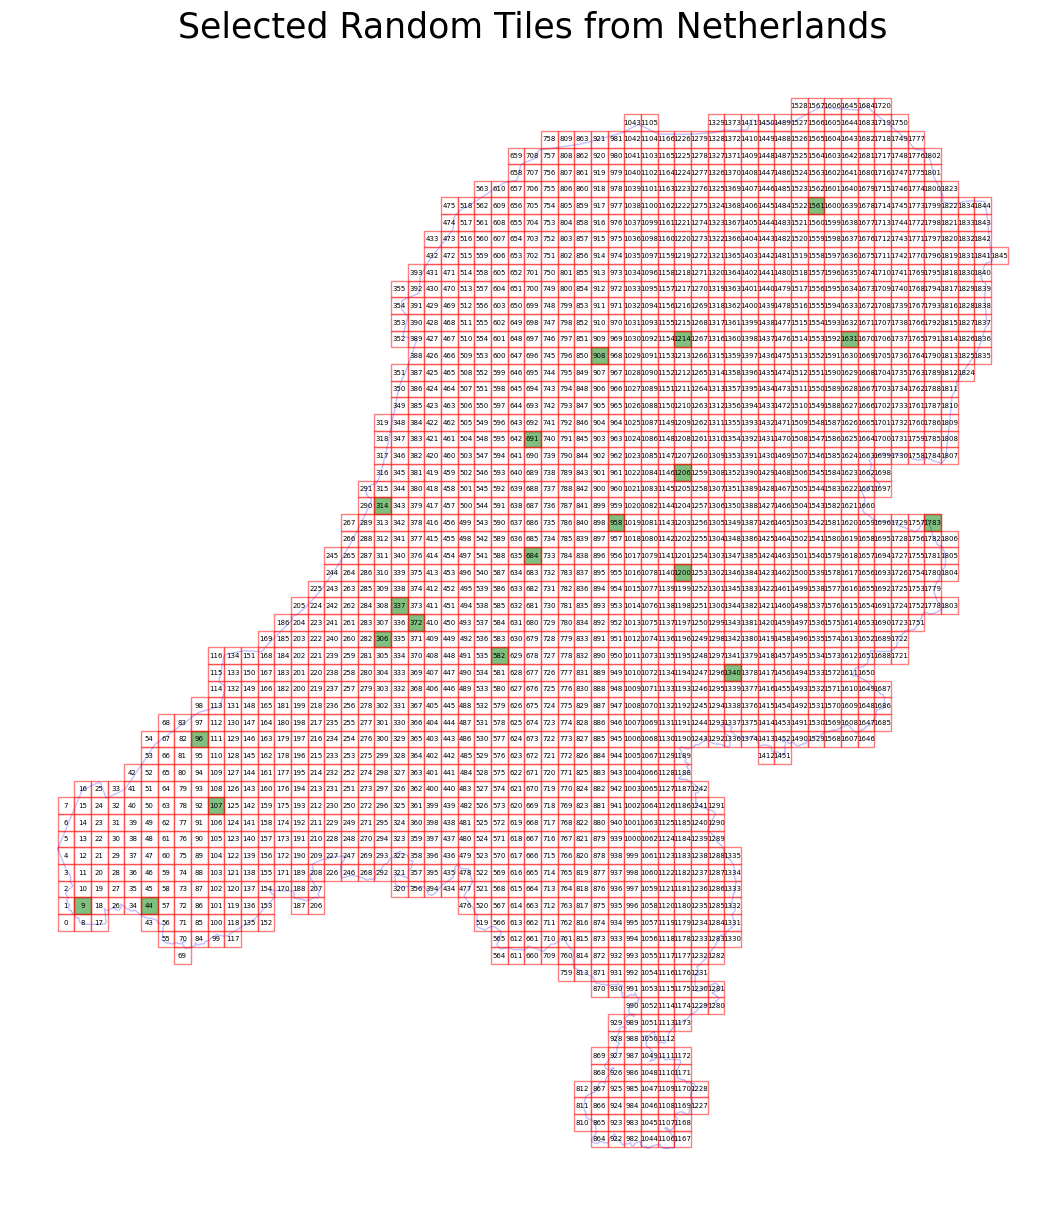

In [6]:
# Display bboxes over country
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Selected Random Tiles from Netherlands", fontsize=25)
country.plot(ax=ax, facecolor="w", edgecolor="b", alpha=0.5)
bbox_gdf.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)

for bbox in bbox_gdf.itertuples():
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, bbox.index, ha="center", va="center", fontsize=5)

# Mark bboxes of selected area
bbox_gdf[bbox_gdf.index.isin(patch_ids)].plot(ax=ax, facecolor="g", edgecolor="r", alpha=0.5)

plt.axis("off");

### Work Flows

#### Access Data

Here we define a workflow which gets all the data we will need into the EOPatches.

For this first we get the HRVPP data. This is our input data to the model. Then we also get cloud free true color Sentinel 2 data which we need later for some visualization.

Then the Ground Truth Data is imported with the `VectorImportTask`. The following tasks already do some data preparation for the ground truth data. The AddLabelTask adds an numeric label. The vectors are then transformed to rasters using this label as the value. Finally the dates in the input data get transformed from a format like YYDOY to a format which records the day since the first of the year.

The EOPatch with this data and the applied transformations is then saved for later use.

In [7]:
evalscript = """

///VERSION=3

function setup() {
  return {
    input: ["AMPL","EOSD","EOSV","LENGTH","LSLOPE","MAXD","MAXV","MINV","QFLAG","RSLOPE","SOSD","SOSV","SPROD","TPROD"],
    output: [{
      id: "BANDS",
      bands: 14,
      sampleType: "UINT16"}],
  }
}
//EvaluatePixel function
function evaluatePixel(sample)
{
  return {
    BANDS: [
      sample.AMPL,
      sample.EOSD,
      sample.EOSV,
      sample.LENGTH,
      sample.LSLOPE,
      sample.MAXD,
      sample.MAXV,
      sample.MINV,
      sample.QFLAG,
      sample.RSLOPE,
      sample.SOSD,
      sample.SOSV,
      sample.SPROD,
      sample.TPROD
    ]
  };
}
"""

In [8]:
true_color_evalscript = """
//VERSION=3
let minVal = 0.0;
let maxVal = 0.4;

let viz = new HighlightCompressVisualizer(minVal, maxVal);

function setup() {
   return {
    input: ["B04", "B03", "B02","dataMask"],
    output: [{
      id: "BANDS_TC",
      bands: 4,
      sampleType: "AUTO"}],
  };
}

function evaluatePixel(samples) {
    let val = [samples.B04, samples.B03, samples.B02,samples.dataMask];
    return viz.processList(val);
}
"""

In [9]:
add_true_color = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "BANDS_TC"),
    evalscript=true_color_evalscript,
    resolution=10,
    time_difference=timedelta(days=7),
    mosaicking_order="leastCC",
    data_collection=DataCollection.SENTINEL2_L2A,
    maxcc=0.8,
    max_threads=5,
    config=config,
)

In [10]:
add_data = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "BANDS"),
    evalscript=evalscript,
    resolution=10,
    time_difference=None,
    data_collection=hrvpp,
    max_threads=5,
    config=config,
)

# SAVING TO OUTPUT (if needed)
save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [11]:
class TransformDatesTask(EOTask):
    def __init__(self, features):
        self.features = features

    def clean_data(self, x_data):
        # features = np.concatenate([eopatch.data["FEATURES_SAMPLED"] for eopatch in x_data], axis=1)
        # Get shape

        arr = x_data[:, :, :, [1, 5, 10]]
        arr = np.nan_to_num(arr, nan=0)

        def yd_to_datetime(yd):
            return None if yd == 0 else datetime.strptime(str(yd), "%y%j")

        def count_days(yd):
            if yd == -1 or yd is None:
                return 0
            else:  # noqa: RET505
                return (yd - datetime(yd.year, 1, 1)).days

        dates = np.vectorize(yd_to_datetime)(arr)
        dates = np.where(dates is None, -1, dates)

        days = np.vectorize(count_days)(dates)
        days = np.where(days is None, 0, days)

        x_data[:, :, :, [1, 5, 10]] = days

        return x_data

    def execute(self, eopatch):
        x_data = eopatch.data[self.features]
        x_data = self.clean_data(x_data)
        eopatch.data[self.features] = x_data
        return eopatch


transformation_task = TransformDatesTask("BANDS")

In [12]:
vector_feature = FeatureType.VECTOR_TIMELESS, "GROUND_TRUTH"

vector_import_task = VectorImportTask(vector_feature, Path("..", "data", "NL_2020_EC21.shp"))


class AddLabelTask(EOTask):
    """
    Adds a label column with the correct dtype to the vector file
    """

    def __init__(self, vector_feature):
        self.vector_feature = vector_feature

    def execute(self, eopatch):
        gpd_df = eopatch.vector_timeless[self.vector_feature]
        gpd_df["label"] = gpd_df.EC_hcat_c.astype(float)
        eopatch.vector_timeless[self.vector_feature] = gpd_df
        return eopatch


add_label_task = AddLabelTask("GROUND_TRUTH")

rasterization_task = VectorToRasterTask(
    vector_feature,
    (FeatureType.MASK_TIMELESS, "LABEL"),
    values_column="label",
    raster_shape=(FeatureType.DATA, "BANDS"),
    raster_dtype=np.uint32,
)

In [13]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(
    add_data, add_true_color, vector_import_task, add_label_task, rasterization_task, transformation_task, save
)
workflow = EOWorkflow(workflow_nodes)

In [14]:
%%time

# Time interval for the SH request
time_interval = ["2016-01-05", "2021-01-05"]

# Define additional parameters of the workflow
input_node = workflow_nodes[0]
save_node = workflow_nodes[-1]
execution_args = []
for idx, bbox in enumerate(bbox_list[patch_ids]):
    execution_args.append(
        {
            input_node: {"bbox": bbox, "time_interval": time_interval},
            save_node: {"eopatch_folder": f"eopatch_{idx}"},
        }
    )

# Execute the workflow
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=1)

# executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

100%|██████████| 20/20 [11:31<00:00, 34.59s/it]

CPU times: user 8min 44s, sys: 33.9 s, total: 9min 18s
Wall time: 11min 31s


#### Sample Data

In this task data is sampled from the ground truth dataset. For this, first the EOPatches created in the previous steps are loaded from disk. Then an Erosion Task is carried out. This erosion task removes pixels on the edges of polygons. This is done because pixels on the edges of polygons are often ambiguous and may contain signals from different land use classes. Doing this erosion thus likely increases the quality and purity of the training data. Afterwards a predetermined fraction of all pixels in the EOPatch are sampled per class. In our case we are sampling a quarter of all pixels. These sampled pixels are then saved again.

In [15]:
# LOAD EXISTING EOPATCHES
load = LoadTask(EOPATCH_FOLDER)

# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS, "LABEL", "LABEL_ERODED"), disk_radius=1)

# SPATIAL SAMPLING
# Uniformly sample pixels from patches

spatial_sampling = FractionSamplingTask(
    features_to_sample=[(FeatureType.DATA, "BANDS", "FEATURES_SAMPLED"), (FeatureType.MASK_TIMELESS, "LABEL_ERODED")],
    sampling_feature=(FeatureType.MASK_TIMELESS, "LABEL_ERODED"),
    fraction=0.25,  # a quarter of points
    exclude_values=[0],
)

save = SaveTask(EOPATCH_SAMPLES_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [16]:
workflow_nodes = linearly_connect_tasks(load, erosion, spatial_sampling, save)
workflow = EOWorkflow(workflow_nodes)

In [17]:
%%time

execution_args = []
for idx in range(len(patch_ids)):
    execution_args.append(
        {
            workflow_nodes[0]: {"eopatch_folder": f"eopatch_{idx}"},  # load
            workflow_nodes[-2]: {"seed": 42},  # sampling
            workflow_nodes[-1]: {"eopatch_folder": f"eopatch_{idx}"},  # save
        }
    )

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5)

# executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

  0%|          | 0/20 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py:122: EODeprecationWarning: "OVERWRITE_PATCH" permission is deprecated and will be removed in a future version
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py:122: EODeprecationWarning: "OVERWRITE_PATCH" permission is deprecated and will be removed in a future version
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py:122: EODeprecationWarning: "OVERWRITE_PATCH" permission is deprecated and will be removed in a future version
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py:122: EODeprecationWarning: "OVERWRITE_PATCH" permission is deprecated and will be removed in a future version
  return _ForkingPickler.loads(res)
/Library/Framework

CPU times: user 81.7 ms, sys: 82.6 ms, total: 164 ms
Wall time: 11.7 s


In [18]:
# Load sampled eopatches
sampled_eopatches = []

for i in range(len(patch_ids)):
    sample_path = EOPATCH_SAMPLES_FOLDER / f"eopatch_{i}"
    sampled_eopatches.append(EOPatch.load(sample_path, lazy_loading=True))

#### Data Preparation outside eo-learn

The sampled EOPatches are split up into a train and test set. The test set will be used for validation and the train set for training the model.

This is the part where we have to move away from eo-learn and convert the data into a format usable by the big machine learning libraries. This means that we now have access to the complete training dataset in one, which allows us to do some more pre-processing.

The first pre-processing step is cleaning the dataset of null values. These values can not be used in the algorithm and are thus discarded. The second step is the normalization of values using a minMax scaler. This gives all input values the same range, from 0-1. This is done so that values which naturally have a bigger numeric range, do not overproportionally impact the model. Finally the data is randomly undersampled to give both classes, Grassland and No Grassland the same amount of samples. This is called balancing the dataset.

In [19]:
# Definition of the train and test patch IDs, take 80 % for train
test_id = rng.choice(len(patch_ids), replace=False, size=int(len(patch_ids) * 0.20))
test_eopatches = [sampled_eopatches[i] for i in test_id]
train_id = [i for i in range(len(patch_ids)) if i not in test_id]
train_eopatches = [sampled_eopatches[i] for i in train_id]


# Set the features and the labels for train and test sets
features_train = np.concatenate(
    [np.expand_dims(eopatch.data["FEATURES_SAMPLED"][-2], axis=0) for eopatch in train_eopatches], axis=1
)
labels_train = np.concatenate([eopatch.mask_timeless["LABEL_ERODED"] for eopatch in train_eopatches], axis=0)


features_test = np.concatenate(
    [np.expand_dims(eopatch.data["FEATURES_SAMPLED"][-2], axis=0) for eopatch in test_eopatches], axis=1
)
labels_test = np.concatenate([eopatch.mask_timeless["LABEL_ERODED"] for eopatch in test_eopatches], axis=0)

# Get shape
t, w1, h, f = features_train.shape
t, w2, h, f = features_test.shape

# Reshape to n x m
features_train = np.moveaxis(features_train, 0, 2).reshape(w1 * h, t * f)
labels_train = labels_train.reshape(w1 * h)
features_test = np.moveaxis(features_test, 0, 2).reshape(w2 * h, t * f)
labels_test = labels_test.reshape(w2 * h)

In [20]:
def clean_null_values(x_data, y_data=None):
    """Transform the data to dataframe and cleans it"""
    x_df = pd.DataFrame(
        x_data,
        columns=[
            "AMPL",
            "EOSD",
            "EOSV",
            "LENGTH",
            "LSLOPE",
            "MAXD",
            "MAXV",
            "MINV",
            "QFLAG",
            "RSLOPE",
            "SOSD",
            "SOSV",
            "SPROD",
            "TPROD",
        ],
    )
    if y_data is not None:
        y_df = pd.DataFrame(y_data, columns=["LABEL"])
        df = x_df.join(y_df)
    else:
        df = x_df
    df = df.dropna()
    df = df[~(df[["EOSD", "SOSD", "MAXD", "LENGTH"]] == 0).any(axis=1)]
    df = df[~(df[["SOSV", "EOSV", "MAXV", "MINV", "AMPL", "LSLOPE", "RSLOPE"]] == 32768).any(axis=1)]
    df = df[~(df[["SPROD", "TPROD"]] == 65535).any(axis=1)]
    return df.drop(["LABEL"], axis=1), df["LABEL"]

In [21]:
features_train, labels_train = clean_null_values(features_train, labels_train)
features_test, labels_test = clean_null_values(features_test, labels_test)

In [22]:
scaler = preprocessing.MinMaxScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

In [23]:
to_classify = [3302000000]  # Grassland
labels_train = np.where(np.isin(labels_train, to_classify), 1, 0)
labels_test = np.where(np.isin(labels_test, to_classify), 1, 0)

In [24]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(features_train, labels_train)

#### Model training

This step does the actual training. Here we use parameters which we identified in the previous notebook. The model is then saved. 

##### LGBM

In [25]:
%%time

# Set up training classes
labels_unique = np.unique(y_resampled)
model = lgb.LGBMClassifier(
    learning_rate=0.1, max_depth=14, num_leaves=300, n_jobs=4, random_state=42
)  # Set up the model

# Train the model
model.fit(X_resampled, y_resampled)

# Save the model
joblib.dump(model, MODELS_FOLDER / "model_reduced_classes.pkl")

[LightGBM] [Info] Number of positive: 210829, number of negative: 210829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3288
[LightGBM] [Info] Number of data points in the train set: 421658, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
CPU times: user 10.9 s, sys: 361 ms, total: 11.2 s
Wall time: 2.67 s


['../models/model_reduced_classes.pkl']

##### Neural Network

In [26]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()
model.add(Dense(64, activation="relu", input_dim=14))
model.add(Dense(64, activation="relu", input_dim=14))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

2023-10-20 14:49:02.024146: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                960       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5185 (20.25 KB)
Trainable params: 5185 (20.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
hist = model.fit(X_resampled, y_resampled, validation_data=(features_test, labels_test), epochs=50, batch_size=100)

Epoch 1/50
4217/4217 [==============================] - 7s 1ms/step - loss: 0.2251 - accuracy: 0.9114 - val_loss: 0.1404 - val_accuracy: 0.9504
Epoch 2/50
4217/4217 [==============================] - 6s 1ms/step - loss: 0.1951 - accuracy: 0.9247 - val_loss: 0.1354 - val_accuracy: 0.9530
Epoch 3/50
4217/4217 [==============================] - 6s 1ms/step - loss: 0.1858 - accuracy: 0.9282 - val_loss: 0.1478 - val_accuracy: 0.9449
Epoch 4/50
4217/4217 [==============================] - 6s 1ms/step - loss: 0.1792 - accuracy: 0.9314 - val_loss: 0.1363 - val_accuracy: 0.9514
Epoch 5/50
4217/4217 [==============================] - 6s 1ms/step - loss: 0.1741 - accuracy: 0.9331 - val_loss: 0.1438 - val_accuracy: 0.9462
Epoch 6/50
4217/4217 [==============================] - 6s 1ms/step - loss: 0.1699 - accuracy: 0.9351 - val_loss: 0.1356 - val_accuracy: 0.9532
Epoch 7/50
4217/4217 [==============================] - 6s 1ms/step - loss: 0.1664 - accuracy: 0.9366 - val_loss: 0.1348 - val_accuracy:

[]

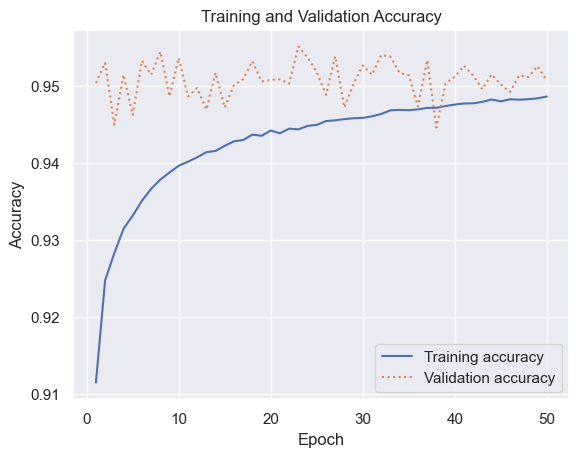

In [28]:
sns.set()
acc = hist.history["accuracy"]
val = hist.history["val_accuracy"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "-", label="Training accuracy")
plt.plot(epochs, val, ":", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.plot()

In [29]:
model.save(MODELS_FOLDER / "dl_sequential.keras")